# Sentiment Analysis in Posts

### Challenge part 2 - JC QUILLET   
   
The object of this notebook is the classification of posts written in Dutch according to the sentiment expressed by the author in a post.  

### Data processing


In [402]:
import json
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from os import listdir

In [354]:
# List of filenames in the folder containing the dataset
filenames = sorted(listdir('dutch_data'))

raw_data = []
for i in range(len(filenames)):
    with open('dutch_data/'+filenames[i]) as f:
        raw_data += json.load(f)

print(raw_data[1])

{'emotion': '', 'other': '', 'source_url': 'http://www.youtube.com/', 'batch_name': 'Seeds_DUTCH_1-1', 'author_gender': '', 'who_curated': 'Brechtje', 'language': 'Dutch', 'categories': '', 'sentiment': 'neutral', 'url': 'https://www.youtube.com/watch?v=2FYB25e0_4E', 'posted_at': 'Wed Sep 21 17:53:52 2016', 'source': 'youtube', 'source_type': 'video', 'author_location': '', 'relevance_2': 'yes', 'author_username': 'Pphvideo', 'topics': '', 'brands': '', 'content': 'Een dorsmachine wordt gebruikt voor het dorsen - ofwel oogsten van graan, rogge of gerst. Voor de opkomst van zelfrijdende dorsers werd gebruik gemaakt van machines aangedreven door een tractor.', 'author_avatar_url': '', 'noise': '', 'author_url': 'http://youtube.com/channel/UCtVRhmseKQa2DcQnMlbwzQQ', 'source_domain': 'www.youtube.com', 'id': '3054dced040ee03753c98ccc77e1638f3db9bbe8', 'author_name': ' '}


The dataset contains categories of information that are not relevant for the sentiment analysis, as URLs or author names.   
Some samples are not useful, as the sentiment is not defined.

In [355]:
# Discard unecessary data
data = pd.DataFrame(raw_data)
data = data[['sentiment','content']]
data = data[data.sentiment != '']
data = data[data.sentiment != 'not sure']
data = data.dropna()
print('Sentiments: {}'.format(data.sentiment.unique())) # Sentiment categories


# Display part of the data loaded
def display_pd(some_df):
    display(HTML(some_df.to_html()))
    
display_pd(data.head(5))
print('{} samples'.format(data.shape[0]))
print('{} positive, {} negative and {} neutral'.format(data[data.sentiment == 'positive'].shape[0],
                                                      data[data.sentiment == 'negative'].shape[0],
                                                       data[data.sentiment == 'neutral'].shape[0]))
print(data.shape)

Sentiments: ['neutral' 'positive' 'negative']


,sentiment,content
1,neutral,Een dorsmachine wordt gebruikt voor het dorsen...
2,neutral,"De plant groeit vanuit een flinke bol,eerst on..."
6,neutral,"Als de temperatuur boven het vriespunt komt, k..."
7,neutral,Wie zijn er nog meer aanwezig? – Lowieke van R...
8,neutral,Tot slot nog een vooraanzicht van de hele kaps...


3166 samples
759 positive, 179 negative and 2228 neutral
(3166, 2)


The dataset is relatively modest in size and also imbalanced, as there are much more neutral samples than any other, and very little negative examples.

In [356]:
''' Clean text data, by removing unecessary characters,
    numbers, urls, that do not add information for sentiment
    analysis.
'''

import re

removeChar = re.compile("[.;:!\'’‘?,\"()\[\]#@%|_–-]")
replaceAmpersand = re.compile("&")
replaceDigits = re.compile('\d+')
removeUrls = re.compile(r'http\S+')
removeMentions = re.compile(r'@[A-Za-z0-9]+')
regex = re.compile(r'\d+(.*?)[\u263a-\U0001f645]')

def preprocess_reviews(reviews):
    reviews = reviews.lower()
    reviews = re.sub(regex, "", reviews)
    reviews = re.sub(removeUrls, "", reviews)
    reviews = re.sub(removeMentions, "", reviews)
    reviews = re.sub(removeChar, "", reviews)
    reviews = re.sub(replaceAmpersand, "en", reviews)
    reviews = re.sub(replaceDigits, "", reviews)
    
    return str(reviews)

data['content'] = data['content'].apply(lambda x : preprocess_reviews(x))
print(data.shape)

(3166, 2)


In [357]:
# Convert the categories to numbers
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
data['label'] = LE.fit_transform(data['sentiment'])
print(data['label'].unique())
print('{} negative, {} neutral and {} positive'.format(data[data.label == 0].shape[0],
                                                       data[data.label == 1].shape[0],
                                                      data[data.label == 2].shape[0]))

[1 2 0]
179 negative, 2228 neutral and 759 positive


In [358]:
# Split the dataset between train and test set for testing purpose.
from sklearn.model_selection import train_test_split

np.random.seed(25)

# As the dataset is imbalanced, each category is split separately
# to ensure that the test set includes all 3 categories.
pos_data = data[data.label == 2].copy(deep = 'True')
neg_data = data[data.label == 0].copy(deep = 'True')
neu_data = data[data.label == 1].copy(deep = 'True')
               
pos_train, pos_test = train_test_split(pos_data, test_size=0.15)
neg_train, neg_test = train_test_split(neg_data, test_size=0.15)
neu_train, neu_test = train_test_split(neu_data, test_size=0.15)

df_train = pd.concat([pos_train, neg_train, neu_train])
df_train.index = pd.RangeIndex(len(df_train.index))
df_test = pd.concat([pos_test, neg_test, neu_test])
df_test.index = pd.RangeIndex(len(df_test.index))

display_pd(df_train.head(5))
print('{} train samples'.format(df_train.shape[0]))
print('{} test samples'.format(df_test.shape[0]))

,sentiment,content,label
0,positive,doordat je plant ben je sneller,2
1,positive,maart is de maand voor het betegelen van het t...,2
2,positive,ik ben uitgeplaatst in de googerpolder waar ni...,2
3,positive,dank voor de retweet wat is haarlem toch mooi...,2
4,positive,bij het bewaren en gebruiken van gewassen die ...,2


2690 train samples
476 test samples


### Feature Extraction

In [258]:
text_corpus = df_train['content'].copy(deep = True) # Use the training part of the dataset

# Apply Sklearns Count Vectorizer to convert the text posts into
# vectors. Each feature in a vector represents the utterances count 
# in a post of each word of the vocabulary.

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(text_corpus)

print('Sample of the vocabulary: {}'.format(vectorizer.get_feature_names()[101:110]))
print('Size of the vocabulary: {} words'.format(len(vectorizer.get_feature_names())))
print('Training set: {}'.format(X_train.toarray()))

Sample of the vocabulary: ['aanverwante', 'aanvliegroute', 'aanvoer', 'aanvraag', 'aanwenden', 'aanwezig', 'aanwezige', 'aanwijzingen', 'aanwinst']
Size of the vocabulary: 12486 words
Training set: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


The dataset obtained with the count vectorizer transformation is very sparse, as only a few words of the full vocabulary are present in each post.

### Initial Modeling   

A Naive Bayes model is a fast and simple classification algorithms with limited parameters and it is suitable for high-dimensional datasets. 
Therefore it is suitable as a baseline for our sentiment classification problem.

In [259]:
# Train our Naive Bayes baseline model.
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB().fit(X_train, df_train['label'])

In [260]:
#Test our Naive Bayes model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_test = vectorizer.transform(df_test['content'])
y_pred = clf.predict(X_test)
print('Accuracy: {}'.format(accuracy_score(df_test['label'], y_pred)))
print('Precision: {}'.format(precision_score(df_test['label'], y_pred, average = 'weighted')))
print('Recall: {}'.format(recall_score(df_test['label'], y_pred, average = 'weighted')))
print('F1 score: {}'.format(f1_score(df_test['label'], y_pred, average = 'weighted')))

Accuracy: 0.7142857142857143
Precision: 0.6854166359543649
Recall: 0.7142857142857143
F1 score: 0.6577926260203399


In [262]:
from sklearn import metrics
print(metrics.classification_report(df_test['label'], y_pred, target_names=['negative', 'neutral', 'positive'],digits = 3))

              precision    recall  f1-score   support

    negative      0.750     0.111     0.194        27
     neutral      0.731     0.940     0.822       335
    positive      0.537     0.193     0.284       114

    accuracy                          0.714       476
   macro avg      0.672     0.415     0.433       476
weighted avg      0.685     0.714     0.658       476



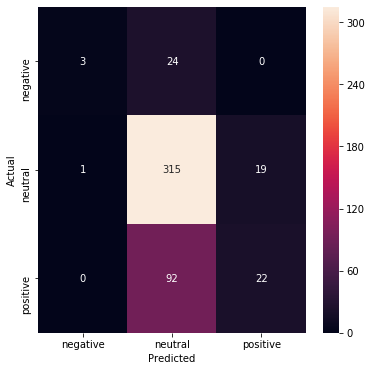

In [263]:
import seaborn as sbn
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(df_test['label'], y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sbn.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

I chose to calculate the metrics 'weighted', meaning that they are calculated for each sentiment category independently and then averaged, because the dataset is imbalanced.
Therefore the metrics reflect the performance on each category equally.   

The F1-score is a good measure of the performance of the model as it consider both the precision and the recall to compute the score.   
A score of 0.658 means that model has a chance higher than random to identify the sentiment in a post, which is interesting considering the imbalanced dataset.   
Nevertheless, this score is largely insufficient for any commercial use.
Specially, the recall is very small for positive and negative categories, meaning that the model misclassify both categories.

We can try to use other models to try to improve that result.

### Modeling   

In this section, we will explore different models and feature extraction options to try to improve the prediction of the sentiment.

In [371]:
text_corpus = data['content'].copy(deep = True) # In this part we use the full dataset available

def vectorize(vectorizer, text):
    vectorizer = vectorizer
    X_train = vectorizer.fit_transform(text)
    return X_train

# Apply Count Vectorizer for feature extraction
X_train = vectorize(CountVectorizer(), text_corpus)

print('Training set: {}'.format(X_train.toarray()))
print(len(X_train.toarray()[0]))

Training set: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
13756


In [343]:
# Define a set of models to train using Cross Validation for estimating their performance.
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    MultinomialNB(),
    RandomForestClassifier(n_estimators=150, max_depth=3, random_state=0),
    AdaBoostClassifier(),
    LinearSVC(max_iter = 2500),
    LogisticRegression(solver = 'liblinear', random_state=0, multi_class = 'auto')
]

In [344]:
# As the dataset is imbalanced we will use from now on a stratified shuffle split 
# strategy on the full dataset when evaluating a model potential.
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=42)

In [345]:
# Function to train and evaluate our models
def train_eval(models, X_train, y_train, cv):
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv)
        print(model_name, np.mean(accuracies))

#### First run

In [268]:
train_eval(models, X_train, data['label'], cv)

MultinomialNB 0.6783157894736842
RandomForestClassifier 0.7031578947368421
AdaBoostClassifier 0.704421052631579


/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC 0.6606315789473683
LogisticRegression 0.6896842105263158


The Random Forest and Adaboost models obtain the best performance here. Still, the accuracy reaches only 70.4% which is insufficient for our commercial purpose.   

There is a different method for feature extraction than Count Vectorizer, that intends to reflect how important or meaningful a word is in the text corpus. It computes the product of a term frequency in a document with the log of its inverse frequency in all the documents (term frequency–inverse document frequency).

#### TF-IDF Vectorizer

In [346]:
from sklearn.feature_extraction.text import TfidfVectorizer

text_corpus = data['content'].copy(deep = True) # In this part we use the full dataset available

# Apply Sklearns TF-IDF Vectorizer to convert the text posts into
# vectors. Each feature in a vector represents the utterances count 
# in a post of each word of the vocabulary.
X_train = vectorize(TfidfVectorizer(), text_corpus)

print('Vectors dimension: {}'.format(X_train.toarray()))
print(len(X_train.toarray()[0]))

Vectors dimension: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
13756


In [347]:
train_eval(models, X_train, data['label'], cv)

MultinomialNB 0.7056842105263158
RandomForestClassifier 0.7031578947368421
AdaBoostClassifier 0.6947368421052632
LinearSVC 0.7035789473684211
LogisticRegression 0.7187368421052631


Using TF-IDF for creating the vectors as improved the performance of some models, while reducing for instance the performance of the Adaboost model.
Still, the best accuracy reached by the Logistic Regression model is only 71.8% which is insufficient for our commercial purpose.   

I propose to test an additional pre-processing technique on the text, stemming, to evaluate if it can improve the performance of the models.
Stemming refers to cutting off or slicing any pattern of string-terminal characters that is a suffix. In effect it reduces the vocabulary keeping root of words, ignoring inflected or derived forms of words.

#### Stemming + TF-IDF

In [348]:
# Stemming of the words using NLTK Dutch Stemmer
from nltk.stem.snowball import DutchStemmer

def stemming(input_text):
        stemmer = DutchStemmer()
        words_list = input_text.split() 
        stemmed_words = [stemmer.stem(word) for word in words_list]
        return " ".join(stemmed_words)

stemmed_data = data.copy(deep = True)
stemmed_data['content'] = stemmed_data['content'].apply(lambda x : stemming(x))

In [349]:
text_corpus = stemmed_data['content'].copy(deep = True) # In this part we use the full dataset available

# Apply TFIDF Vectorizer for feature extraction
X_train = vectorize(TfidfVectorizer(), text_corpus)
print('Vectors dimension: {}'.format(len(X_train.toarray()[0])))

Vectors dimension: 12131


In [350]:
train_eval(models, X_train, stemmed_data['label'], cv)

MultinomialNB 0.703578947368421
RandomForestClassifier 0.7031578947368421
AdaBoostClassifier 0.6892631578947368
LinearSVC 0.7018947368421052
LogisticRegression 0.7195789473684211


Using Stemming on the words has not improved the general performance of the models. 

I propose to test an additional processing technique to axtract features from the text, using ngrams, to evaluate if it can improve the performance of the models. Ngrams are pairs of n consecutives words that are added as feature to the vectors, in addition to single words, potentially adding context information. We will limit ourselves to bigrams and trigrams.

#### Ngrams + TF-IDF

In [272]:
text_corpus = data['content'].copy(deep = True)

# Apply TFIDF Vectorizer with bigrams for feature extraction
X_train = vectorize(TfidfVectorizer(ngram_range=(1, 2)), text_corpus)
print('Vectors dimension: {}'.format(len(X_train.toarray()[0])))

Vectors dimension: 67067


In [226]:
train_eval(models, X_train, data['label'], cv)

MultinomialNB 0.704
RandomForestClassifier 0.7031578947368421
AdaBoostClassifier 0.6989473684210525
LinearSVC 0.7103157894736842
LogisticRegression 0.7035789473684211


In [273]:
text_corpus = data['content'].copy(deep = True)

# Apply TFIDF Vectorizer with trigrams for feature extraction
X_train = vectorize(TfidfVectorizer(ngram_range=(1, 3)), text_corpus)
print('Vectors dimension: {}'.format(len(X_train.toarray()[0])))

Vectors dimension: 138895


In [229]:
train_eval(models, X_train, data['label'], cv)

MultinomialNB 0.7027368421052632
RandomForestClassifier 0.7031578947368421
AdaBoostClassifier 0.7002105263157895
LinearSVC 0.7069473684210525
LogisticRegression 0.7018947368421052


Using N-grams on the words has not improved the general performance of the models. In addition, the extra-features make the models slower to train.

I propose to test the removal of stop words from the test to verify if this will have an effect on the performance of the model.
Stop words are very common words in a language that potentially do not add much meaning information to the sentence. 

#### Stop words removal

In [231]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('dutch'))
print('Stop words in Dutch', stop_words)
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('dutch')) + r')\b\s*')

def stopwords_reviews(reviews):
    reviews = re.sub(pattern, "", reviews)
    
    return str(reviews)

stopwords_data = data.copy(deep = True)
stopwords_data['content'] = stopwords_data['content'].apply(lambda x : stopwords_reviews(x))

Stop words in Dutch {'of', 'meer', 'haar', 'om', 'altijd', 'eens', 'tegen', 'kunnen', 'je', 'een', 'na', 'wie', 'wil', 'hun', 'van', 'heb', 'niet', 'is', 'waren', 'veel', 'heeft', 'ja', 'daar', 'reeds', 'op', 'zal', 'te', 'geen', 'zijn', 'uw', 'onder', 'zou', 'bij', 'moet', 'zich', 'kon', 'die', 'ik', 'kan', 'maar', 'wordt', 'met', 'hier', 'iets', 'mij', 'zonder', 'de', 'was', 'nog', 'want', 'hebben', 'over', 'zelf', 'er', 'ook', 'alles', 'wat', 'der', 'dus', 'en', 'al', 'het', 'men', 'aan', 'had', 'dan', 'hem', 'zo', 'u', 'wezen', 'toch', 'dit', 'doen', 'worden', 'hij', 'ons', 'door', 'ge', 'me', 'toen', 'uit', 'ze', 'niets', 'tot', 'ben', 'voor', 'zij', 'hoe', 'deze', 'in', 'dat', 'naar', 'nu', 'andere', 'mijn', 'werd', 'omdat', 'geweest', 'als', 'doch', 'iemand'}


In [232]:
text_corpus = data['content'].copy(deep = True)

# Apply TFIDF Vectorizer with trigrams for feature extraction
X_train = vectorize(TfidfVectorizer(), text_corpus)
print('Vectors dimension: {}'.format(len(X_train.toarray()[0])))

Vectors dimension: 13756


In [233]:
train_eval(models, X_train, data['label'], cv)

MultinomialNB 0.7056842105263158
RandomForestClassifier 0.7031578947368421
AdaBoostClassifier 0.6955789473684211
LinearSVC 0.7035789473684211
LogisticRegression 0.7187368421052631


The removal of the stopwords has also little to no effect on the performance of the models.

I propose to try to fine tune our best performing model to improve the performance. The Logistic regression model has reached the best accuracy, and typically perform well on sentiment analysis, as they can handle very sparse data. We will try to optimize this model.

#### Logistic Regression model tuning   
   
I decide not to conduct a brute force search over the parameters of this model, as there a not so many to try and that depending on the solver, not all configurations are possible.
2 solvers are tested that can perform with relatively small datasets.
The multinomial option is tested too (available with lbfgs only).
Finally, as we have imbalanced classes, we try to weight them inversely to their frequency.

In [274]:
text_corpus = data['content'].copy(deep = True) # In this part we use the full dataset available

# Apply TFIDF Vectorizer for feature extraction
X_train = vectorize(TfidfVectorizer(), text_corpus)
print('Vectors dimension: {}'.format(len(X_train.toarray()[0])))

Vectors dimension: 13756


In [236]:
models = [
    LogisticRegression(solver = 'liblinear', random_state=0, multi_class = 'auto'),
    LogisticRegression(solver = 'lbfgs', random_state=0, multi_class = 'multinomial'),
    LogisticRegression(solver = 'lbfgs', random_state=0, multi_class = 'multinomial', class_weight = 'balanced')
]

train_eval(models, X_train, data['label'], cv)

LogisticRegression 0.7187368421052631
LogisticRegression 0.7195789473684211
LogisticRegression 0.6416842105263159


We obtain the best performance with the sover set to 'lbfgs' and non-differentiated class weights and reach an accuracy or 71.9%.

#### Imbalance reduction using SMOTE    

I propose to use, SMOTE, an over-sampling method. It creates synthetic samples of the minority class.

In [372]:
text_corpus = df_train['content'].copy(deep = True) # In this part we use the full dataset available

# Apply Sklearns TF-IDF Vectorizer 
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(text_corpus)
print('Vectors dimension: {}'.format(len(X_train.toarray()[0])))

Vectors dimension: 12486


In [373]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_sample(X_train, df_train['label'])
print('Original train samples: {}, Over-sampled samples: {}'.format(X_train.shape[0],X_sm.shape[0]))
clf = LogisticRegression(solver = 'lbfgs', random_state=0, multi_class = 'multinomial')
clf.fit(X_sm,y_sm)
test_corpus = df_test['content'].copy(deep = True)
ytest = vectorizer.transform(test_corpus)
y_pred = clf.predict(ytest)

print(metrics.classification_report(df_test['label'], y_pred, target_names=['negative', 'neutral', 'positive'],digits = 3))

Original train samples: 2690, Over-sampled samples: 5679
              precision    recall  f1-score   support

    negative      0.310     0.333     0.321        27
     neutral      0.784     0.770     0.777       335
    positive      0.483     0.500     0.491       114

    accuracy                          0.681       476
   macro avg      0.526     0.534     0.530       476
weighted avg      0.685     0.681     0.683       476



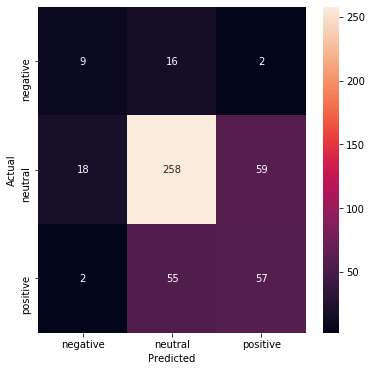

In [311]:
conf_mat = confusion_matrix(df_test['label'], y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sbn.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The overall performance of the model has decreased. Nevertheless, we can see that the recall for neutral and positive categories has improved a lot.

#### Reduction of data imbalance

One way of reducing imbalance is to reduce the set of the over-represented category.
We try a differenct train/test split for that purpose.
The side-effect will be that the vocabulary vectorised may be less rich, but this would affect the neutral category mostly.

In [312]:
# Split the dataset between train and test set.
from sklearn.model_selection import train_test_split

np.random.seed(25)
# As the dataset is imbalanced, categories are split separately
# to ensure that the test set includes all 3 categories.
pos_data = data[data.label == 2].copy(deep = 'True')
neg_data = data[data.label == 0].copy(deep = 'True')
neu_data = data[data.label == 1].copy(deep = 'True')
               
pos_train, pos_test = train_test_split(pos_data, test_size=0.15)
neg_train, neg_test = train_test_split(neg_data, test_size=0.15)
neu_train, neu_test = train_test_split(neu_data, test_size=0.5)

df_train = pd.concat([pos_train, neg_train, neu_train])
df_train.index = pd.RangeIndex(len(df_train.index))
df_test = pd.concat([pos_test, neg_test, neu_test])
df_test.index = pd.RangeIndex(len(df_test.index))

print('{} train samples'.format(df_train.shape[0]))
print('{} test samples'.format(df_test.shape[0]))

1911 train samples
1255 test samples


In [313]:
text_corpus = df_train['content'].copy(deep = True) # In this part we use the full dataset available

# Apply Sklearns TF-IDF Vectorizer to convert the text posts into
# vectors. Each feature in a vector represents the utterances count 
# in a post of each word of the vocabulary.
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(text_corpus)
print('Vectors dimension: {}'.format(len(X_train.toarray()[0])))

Vectors dimension: 10080


In [314]:
clf = LogisticRegression(solver = 'lbfgs', random_state=0, multi_class = 'multinomial', class_weight = 'balanced')
#clf.fit(X_train,df_train.label)


sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_sample(X_train, df_train['label'])
clf.fit(X_sm,y_sm)


X_test = vectorizer.transform(df_test['content'])
y_pred = clf.predict(X_test)

print(metrics.classification_report(df_test['label'], y_pred, target_names=['negative', 'neutral', 'positive'],digits = 3))

              precision    recall  f1-score   support

    negative      0.100     0.370     0.157        27
     neutral      0.923     0.665     0.773      1114
    positive      0.182     0.561     0.275       114

    accuracy                          0.649      1255
   macro avg      0.402     0.532     0.402      1255
weighted avg      0.838     0.649     0.715      1255



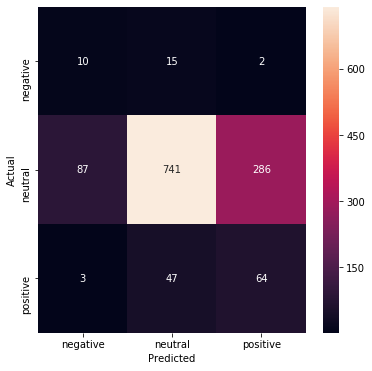

In [315]:
conf_mat = confusion_matrix(df_test['label'], y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sbn.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

This test is clearly not giving us any positive result, the precision for positive and negative samples has dropped.

#### Attempt at binary classification   
   
Typically, binary classification will be a less complex problem over this dataset. We can try to train a binary classifier to separate opinionated posts (both positive and negative) from neutral posts.

In [376]:
df_binary = data.copy(deep = True) # In this part we use the full dataset available

df_binary['label'] = df_binary['label'].replace(2,0)
print(df_binary['label'].unique())

[1 0]


In [377]:
# Split the dataset between train and test set.
from sklearn.model_selection import train_test_split

np.random.seed(25)
# As the dataset is imbalanced, categories are split separately
# to ensure that the test set includes all 3 categories.
pos_data = df_binary[data.label == 0].copy(deep = 'True')
neu_data = df_binary[data.label == 1].copy(deep = 'True')
               
pos_train, pos_test = train_test_split(pos_data, test_size=0.15)
neu_train, neu_test = train_test_split(neu_data, test_size=0.15)

df_train = pd.concat([pos_train, neg_train, neu_train])
df_train.index = pd.RangeIndex(len(df_train.index))
df_test = pd.concat([pos_test, neg_test, neu_test])
df_test.index = pd.RangeIndex(len(df_test.index))

print('{} train samples'.format(df_train.shape[0]))
print('{} test samples'.format(df_test.shape[0]))

2197 train samples
389 test samples


In [319]:
text_corpus = df_train['content'].copy(deep = True)

# Apply Sklearns TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train = vectorizer.fit_transform(text_corpus)
print('Vectors dimension: {}'.format(len(X_train.toarray()[0])))

Vectors dimension: 99167


In [323]:
clf = LogisticRegression(solver = 'lbfgs', random_state=0, C = 1, multi_class = 'multinomial', class_weight = 'balanced')
clf.fit(X_train,df_train['label'])


X_test = vectorizer.transform(df_test['content'])
y_pred = clf.predict(X_test)

print('Accuracy: {}'.format(accuracy_score(df_test['label'], y_pred)))
print(metrics.classification_report(df_test['label'], y_pred, target_names=['pos_neg', 'neutral'],digits = 3))

Accuracy: 0.9383033419023136
              precision    recall  f1-score   support

     pos_neg      0.727     0.889     0.800        54
     neutral      0.981     0.946     0.964       335

    accuracy                          0.938       389
   macro avg      0.854     0.918     0.882       389
weighted avg      0.946     0.938     0.941       389



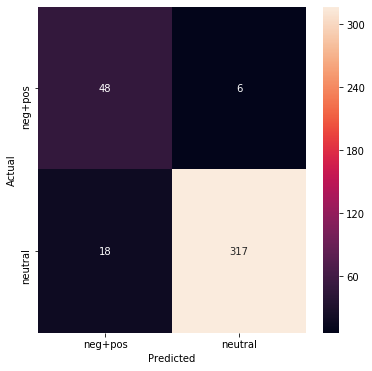

In [322]:
conf_mat = confusion_matrix(df_test['label'], y_pred)
fig, ax = plt.subplots(figsize=(6,6))
sbn.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['neg+pos', 'neutral'], yticklabels=['neg+pos', 'neutral'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

As expected, the performance of our model is much higher in this case.
The accuracy reaches 93.8 % and the F1 score for the positive/negative category reaches 80%.

This information is interesting since we can detect and separate the most interesting posts and then try to build a classifier to evaluate the sentiment on this subset.   
   
We try below to build a classifier between positive and negative posts.

In [388]:
df_pos_neg = data[data.label != 1].copy(deep = 'True')
df_pos_neg['label'] = df_pos_neg['label'].replace(2,1)
print(df_pos_neg['label'].unique())

[1 0]


In [389]:
text_corpus = df_pos_neg['content'].copy(deep = True)

# Apply TFIDF Vectorizer with trigrams for feature extraction
vectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train = vectorizer.fit_transform(text_corpus)
print('Vectors dimension: {}'.format(len(X_train.toarray()[0])))

Vectors dimension: 47308


In [390]:
models = [
    LogisticRegression(solver = 'liblinear', random_state=0, multi_class = 'auto', class_weight = 'balanced')
]

train_eval(models, X_train, df_pos_neg['label'], cv)

LogisticRegression 0.8595744680851064


Here we manage to obtain a classifier with an accuracy of 86% to distinguish positive from negative posts.

## Conclusion   


I had a limited success at building a classifier that can differentiate properly post from the 3 sentiment categories, specially for the 2 less represented categories for which we have a lot of false negative. Nevertheless, the problem could be split more successfully into binary classification.
It also was the opportunity to evaluate what should be the next steps to solve this problem.

After analysing many options, I can make the following observations:   
- One issue comes from the imbalanced nature of dataset, that has very few negative examples,
- A second issue comes from the limited size of the annotated data, with 3166 annotated samples in total.

So one of the priority action I would take for this is to collect more data.

To improve the performace of our classification model we can:
- Try to collect and annotate more data, in particular from the negative and positive category. It must be noted that the imbalanced dataset probably reflect the actual distribution of the posts that we are trying to categorize,
- Other type of models can give us higher performance, like neural network or even Deep Network. However, they require more data to be trained than what we hav now to outperform more classic Machine Learning algorithm,
- Other type of feature vectors can be built from the corpus of text, using word embedding models like Word2vec or Glove. They learn a richer representation of the vocabulary, associating words of similar meaning for instance. It requires a larger text corpus to build, for which we can use the non-labelled data we have for instance, but it will handle better unseen words. Such model can also be found pre-trained and will translate very well for any application requiring vectorization of texts.
- Another method is to train a set of models, and using ensemble techniques to combine their predictions. This is for instance one of the principle behind the Adaboost algorithm tested here, but it can be applied to othe type of base models.